In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/banglorehousepricepredictions/Test.csv
/kaggle/input/banglorehousepricepredictions/Train.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
os.chdir('/kaggle/input/banglorehousepricepredictions/')
train=pd.read_csv('Train.csv')
test=pd.read_csv('Test.csv')
train_copy=pd.read_csv('Train.csv')
train.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


Skewness : 8.064469
Kurtosis : 108.166513


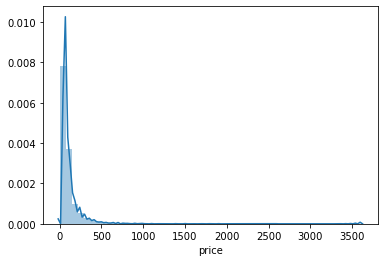

In [3]:
# Skewness and Kurtosis
print("Skewness : %f" % train['price'].skew())
print("Kurtosis : %f" % train['price'].kurt())
sns.distplot(train.price)

In [4]:
train = train.dropna(axis=0, subset=['location'])
test = test.dropna(axis=0, subset=['location']) 
train_copy = train_copy.dropna(axis=0, subset=['location']) 
targets= np.log1p(train.price)
#targets= train.price


train.drop(['price'], inplace=True, axis=1)
test.drop(['price'], inplace=True, axis=1) # even the test data had a price column :p
train_copy['price']= np.log1p(train_copy.price)

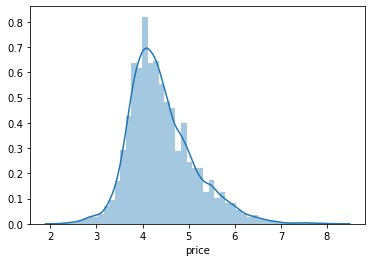

In [5]:
# the prices are highly skewed, lets do a log1p tranform and check the distribution
sns.distplot(targets)
# now the target variable is nicely distributed (log1p means (log(x+1)))

In [6]:
print("Skewness : %f" % targets.skew())
print("Kurtosis : %f" % targets.kurt())

Skewness : 0.856272
Kurtosis : 1.347649


In [7]:
#handling missing values
train = train.dropna(axis=0, subset=['location'])
test = test.dropna(axis=0, subset=['location']) 
train_copy = train_copy.dropna(axis=0, subset=['location']) 
train_copy=train_copy.astype(str)
train_copy['price']=train_copy['price'].astype(float)
all_data=pd.concat([train,test])
all_data=all_data.astype(str)
all_data.shape

(14799, 8)

Features that can be created !
1. avg price of area_type
2. avg price of location
3. total_sqft can be made into interval-categories
4. price per area_type and location
5. price per size
and few more similar features can be created

model that i will use initiallhy will be catboost regressor and lightgbm regressor, then i can train more models and do blended predictions

I think there are some duplicate values in location(because of spelling mistakes, correct them)


In [8]:
# feature engineering
features=pd.DataFrame()
avg_price_of_area_type=pd.DataFrame(train_copy['price'].groupby(train_copy['area_type']).mean()).reset_index()
avg_price_of_location=pd.DataFrame(train_copy['price'].groupby(train_copy['location']).mean()).reset_index()
avg_price_of_society=pd.DataFrame(train_copy['price'].groupby(train_copy['society']).mean()).reset_index()
avg_price_bath_count=pd.DataFrame(train_copy['price'].groupby(train_copy['bath']).mean()).reset_index()
avg_price_balcony_count=pd.DataFrame(train_copy['price'].groupby(train_copy['balcony']).mean()).reset_index()
avg_price_location_area=train_copy.groupby(['location', 'area_type'])['price'].mean()
avg_price_location_size=train_copy.groupby(['location', 'size'])['price'].mean()
avg_price_location_bath=train_copy.groupby(['location', 'bath'])['price'].mean()
avg_price_location_balcony=train_copy.groupby(['location', 'balcony'])['price'].mean()
avg_price_society_area_type=train_copy.groupby(['society', 'area_type'])['price'].mean()
avg_price_society_bath=train_copy.groupby(['society', 'bath'])['price'].mean()
avg_price_society_balcony=train_copy.groupby(['society', 'balcony'])['price'].mean()
avg_price_society_size=train_copy.groupby(['society', 'size'])['price'].mean()
avg_price_areatype_size=train_copy.groupby(['area_type', 'size'])['price'].mean()
avg_price_areatype_bath=train_copy.groupby(['area_type', 'bath'])['price'].mean()
avg_price_areatype_balcony=train_copy.groupby(['area_type', 'balcony'])['price'].mean()
avg_price_location_area=pd.DataFrame(avg_price_location_area.reset_index())
avg_price_location_size=pd.DataFrame(avg_price_location_size.reset_index())
avg_price_location_bath=pd.DataFrame(avg_price_location_bath.reset_index())
avg_price_location_balcony=pd.DataFrame(avg_price_location_balcony.reset_index())
avg_price_society_area_type=pd.DataFrame(avg_price_society_area_type.reset_index())
avg_price_society_bath=pd.DataFrame(avg_price_society_bath.reset_index())
avg_price_society_balcony=pd.DataFrame(avg_price_society_balcony.reset_index())
avg_price_society_size=pd.DataFrame(avg_price_society_size.reset_index())
avg_price_areatype_size=pd.DataFrame(avg_price_areatype_size.reset_index())
avg_price_areatype_bath=pd.DataFrame(avg_price_areatype_bath.reset_index())
avg_price_areatype_balcony=pd.DataFrame(avg_price_areatype_balcony.reset_index())
# think later if more features can be formed

In [9]:
all_features=all_data.merge(avg_price_of_area_type, on='area_type',how='outer')
all_features=all_features.merge(avg_price_of_location, on='location',how='outer')
all_features=all_features.merge(avg_price_of_society, on='society',how='outer')
all_features=all_features.merge(avg_price_bath_count, on='bath',how='outer')
all_features=all_features.merge(avg_price_balcony_count, on='balcony',how='outer')
all_features.columns=['area_type', 'availability', 'location', 'size', 'society','total_sqft', 'bath', 'balcony','avg_price_of_area_type','avg_price_of_location','avg_price_of_society','avg_price_bath_count','avg_price_balcony_count']
#all_features.head()

In [10]:
all_features=all_features.merge(avg_price_location_area, on=['area_type','location'],how='outer')
all_features=all_features.merge(avg_price_location_size, on=['size','location'],how='outer')
all_features=all_features.merge(avg_price_location_bath, on=['bath','location'],how='outer')
all_features=all_features.merge(avg_price_location_balcony, on=['balcony','location'],how='outer')
all_features=all_features.merge(avg_price_society_bath, on=['society','bath'],how='outer')
all_features=all_features.merge(avg_price_society_balcony, on=['society','balcony'],how='outer')
all_features=all_features.merge(avg_price_society_size, on=['society','size'],how='outer')
all_features=all_features.merge(avg_price_areatype_size, on=['area_type','size'],how='outer')
all_features=all_features.merge(avg_price_areatype_bath, on=['area_type','bath'],how='outer')
all_features=all_features.merge(avg_price_areatype_balcony, on=['area_type','balcony'],how='outer')
all_features.columns=['area_type', 'availability', 'location', 'size', 'society','total_sqft', 'bath', 'balcony','avg_price_of_area_type','avg_price_of_location','avg_price_of_society','avg_price_bath_count','avg_price_balcony_count',
                     'avg_price_location_area','avg_price_location_size','avg_price_location_bath','avg_price_location_balcony','avg_price_society_bath',
                     'avg_price_society_balcony','avg_price_society_size','avg_price_areatype_size','avg_price_areatype_bath','avg_price_areatype_balcony']
#all_features.head()

In [11]:
all_features['avg_price_of_location']=all_features['avg_price_of_location'].fillna(all_features['avg_price_of_location'].mean())
all_features['avg_price_of_society']=all_features['avg_price_of_society'].fillna(all_features['avg_price_of_society'].mean())
all_features['avg_price_location_area']=all_features['avg_price_location_area'].fillna(all_features['avg_price_location_area'].mean())
all_features['avg_price_location_size']=all_features['avg_price_location_size'].fillna(all_features['avg_price_location_size'].mean())
all_features['avg_price_location_bath']=all_features['avg_price_location_bath'].fillna(all_features['avg_price_location_bath'].mean())
all_features['avg_price_location_balcony']=all_features['avg_price_location_balcony'].fillna(all_features['avg_price_location_balcony'].mean())
all_features['avg_price_society_bath']=all_features['avg_price_society_bath'].fillna(all_features['avg_price_society_bath'].mean())
all_features['avg_price_society_balcony']=all_features['avg_price_society_balcony'].fillna(all_features['avg_price_society_balcony'].mean())
all_features['avg_price_society_size']=all_features['avg_price_society_size'].fillna(all_features['avg_price_society_size'].mean())
all_features['avg_price_areatype_size']=all_features['avg_price_areatype_size'].fillna(all_features['avg_price_areatype_size'].mean())
all_features['avg_price_areatype_bath']=all_features['avg_price_areatype_bath'].fillna(all_features['avg_price_areatype_bath'].mean())


In [23]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
cat_features_indices=np.where(all_features.dtypes != np.float)[0]

for index in cat_features_indices:
    col=traindata.columns[index]
    le.fit(all_features[col])
    all_features[col]=le.transform(all_features[col])

traindata=all_features[:targets.shape[0]]
testdata= all_features[targets.shape[0]:]

inputs= traindata
X=traindata
cat_features_indices

array([0, 1, 2, 3, 4, 5, 6, 7])

In [63]:

import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
dftrainLGB = lgb.Dataset(data = traindata, label = targets, feature_name = list(traindata))
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'max_depth': 10,
    'bagging_fraction':0.8,
    'learning_rate': 0.001,
    'verbose': 0, 
    'early_stopping_round': 20}
cv_results = lgb.cv(
        params,
        dftrainLGB,
        num_boost_round=1000,
        nfold=3,
        metrics='mae',

        # This is what I added
        stratified=False
        )
print(cv_results)

{'l1-mean': [0.549000567534268, 0.5489999646210518, 0.5489990405858252, 0.5489985085071236, 0.5489977408807208, 0.5489973030918464, 0.5489966827336388, 0.5489962459949513, 0.548995535683613, 0.5489951214646739, 0.5489947116091726, 0.5489942862822693, 0.5489939818350336, 0.5489929871469211, 0.5489925733319277, 0.54899171673141, 0.5489910529786254, 0.5489901689211864, 0.5489896064080474, 0.548988983024488, 0.5489883678281696, 0.5489876633435621, 0.5489871676174453, 0.5489866258116632, 0.5489861418018656, 0.5489854902317818, 0.5489854213860844, 0.5489848307877015, 0.5489848531022862, 0.548984213563695, 0.5489842818352589, 0.5489845949181148, 0.5489843728174552, 0.5489840895567906, 0.5489841640873061, 0.5489840017965948], 'l1-stdv': [0.0041355158948482825, 0.004136743255015801, 0.004138134069578265, 0.0041394447232880535, 0.004140903445231931, 0.004142212568339322, 0.00414366978511033, 0.004144977245886755, 0.004146383751993306, 0.004147689682415663, 0.004148753003590478, 0.004150175656577

In [80]:
from lightgbm import LGBMRegressor


lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.001, 
                       n_estimators=1000,
                       max_bin=100, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=100,
                        )

In [81]:
lightgbm.fit(traindata, targets ,verbose=200 )

LGBMRegressor(bagging_fraction=0.8, bagging_freq=4, bagging_seed=8,
              feature_fraction=0.2, feature_fraction_seed=8,
              learning_rate=0.001, max_bin=100, min_sum_hessian_in_leaf=11,
              n_estimators=1000, num_leaves=6, objective='regression',
              random_state=100, verbose=-1)

In [82]:
lightgbm.feature_importances_

array([ 41, 235, 393, 109, 222, 355, 106, 108, 101, 255, 345, 118,  80,
       243, 320, 268, 317, 224, 267, 326, 171, 194, 202], dtype=int32)

In [84]:
pred_lgb=pd.DataFrame(lightgbm.predict(testdata))
pred_lgb=np.expm1(pred_lgb)
pred_lgb.describe()

,0
count,1480.000000
mean,81.520981
std,0.717863
min,79.240513
25%,81.084641
50%,81.486432
75%,81.965523
max,85.042062


In [ ]:
from catboost import CatBoostRegressor
os.chdir('/kaggle/working/')
#from sklearn.model_selection import train_test_split
#X_train, 
cb = CatBoostRegressor(iterations=500,
    loss_function = 'MAE',
    eval_metric = 'RMSE',task_type='GPU',
    cat_features = cat_features_indices )

In [ ]:

cb.fit(traindata, targets ,verbose=200 ,early_stopping_rounds=10)

In [ ]:
#t=t.astype(str)
#t.drop(['price'], inplace=True)
preds=pd.DataFrame(cb.predict(testdata))
preds=np.expm1(preds)
preds.describe()

In [ ]:
os.chdir('/kaggle/working/')
preds.columns=['price']
preds.to_csv('sub4.csv', index=False)


In [ ]:
all_features.area_type.value_counts(dropna=False) # no problem here
all_features.availability.value_counts(dropna=False) # will have to transform this feature somehow, one option could be by interval of dates
all_features.location.value_counts(dropna=False) # 1 NaN value, and lots of values with count 1, will have to sove this problem
all_features.society.value_counts(dropna=False) # 5502 NaN value, and lots of values with count 1, will have to sove this problemtrain.society.value_counts(dropna=False) # 5502 NaN value, and lots of values with count 1, will have to sove this problem
all_features.total_sqft.value_counts(dropna=False) # shoul i treat this as a numerical var or cat var
all_features.bath.value_counts(dropna=False) # 73 Nan values
all_features.society.value_counts(dropna=False) # 609 Nan values

# checkout imputer to handle missing values

In [ ]:
# sklearns imputer works only for numerical varibles, hence is not of any use here as all our vars are cat vars
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df_imputed = imputer.fit_transform(train)



In [ ]:
train.columns

In [ ]:
!pip install datawig

In [ ]:
os.chdir('/kaggle/working/')
import datawig
training_data=train.copy()
training_data = training_data.dropna(axis=0, subset=['balcony'])
training_data=training_data.astype(str)
df_train, df_test = datawig.utils.random_split(training_data)

#Initialize a SimpleImputer model
imputer = datawig.SimpleImputer(
    input_columns=['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath'], # column(s) containing information about the column we want to impute
    output_column= 'balcony', # the column we'd like to impute values for
    output_path = 'imputer_model' # stores model data and metrics
    )

#Fit an imputer model on the train data
imputer.fit(train_df=df_train, num_epochs=50)

#Impute missing values and return original dataframe with predictions
imputed = imputer.predict(df_test)

In [ ]:
imputed = imputer.predict(train.astype(str))
imputed.shape

In [ ]:
imputed.balcony_imputed.value_counts(dropna=False)

In [ ]:
imputed.head(20)

In [ ]:
training_data=train.copy()
training_data = training_data.dropna(axis=0, subset=['bath'])
training_data=training_data.astype(str)
df_train, df_test = datawig.utils.random_split(training_data)

#Initialize a SimpleImputer model
imputer_bath = datawig.SimpleImputer(
    input_columns=['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'balcony'], # column(s) containing information about the column we want to impute
    output_column= 'bath', # the column we'd like to impute values for
    output_path = 'imputer_model' # stores model data and metrics
    )

#Fit an imputer model on the train data
imputer_bath.fit(train_df=df_train, num_epochs=50)
imputed_bath = imputer_bath.predict(train.astype(str))

In [ ]:
corr = all_features.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2) 
# check the correlation later again after the created features are added to df

In [ ]:
# outlier handling

In [ ]:
# Remove highly correlated variables
# Threshold for removing correlated variables
threshold = 0.8

# Absolute value correlation matrix
# first remove price from train df
corr_matrix = train.corr().abs()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Remove the columns
#train = train.drop(columns = to_drop)

In [ ]:
# remove zero importance features
import lightgbm as lgb
from sklearn.model_selection import train_test_split

def identify_zero_importance_features(X, y, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(X.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMRegressor(objective='regression', boosting_type = 'goss', 
                               n_estimators =550, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(X, y, 
                                                                            test_size = 0.25, 
                                                                            random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, 
                  eval_set = [(valid_features, valid_y)])

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(X.columns), 
                            'importance': feature_importances}).sort_values('importance', 
                                                                            ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

zero_features, feature_importances = identify_zero_importance_features(X, y, iterations = 2)
print('zero_features:',zero_features)
print('feature_importances : ', feature_importances)